In [ ]:
# Установим необходимые библиотеки
# !pip install transformers datasets peft accelerate torch tqdm evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_BASE = '/content/drive/MyDrive/ВКР/EmotionClassifier'  
!mkdir -p "{DRIVE_BASE}/bert-head" "{DRIVE_BASE}/bert-full" "{DRIVE_BASE}/bert-lora"

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from evaluate import load as load_metric

df = pd.read_csv('undersampled_dusha_crowd.csv')  
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  

# train/val/test split (80/10/10), stratified
train_val, test = train_test_split(df, test_size=0.1, stratify=df['final_emotion'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1111, stratify=train_val['final_emotion'], random_state=42)

# создаём HuggingFace Dataset
for name, subset in [('train', train), ('val', val), ('test', test)]:
    ds = Dataset.from_pandas(subset[['speaker_text','final_emotion']])
    ds = ds.rename_column('speaker_text', 'text')
    ds = ds.rename_column('final_emotion', 'label')
    # конвертим строки-метки в ClassLabel
    ds = ds.class_encode_column('label')
    globals()[f"ds_{name}"] = ds

ds_train.features

Casting to class labels:   0%|          | 0/35865 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4483 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4484 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['angry', 'neutral', 'positive', 'sad'], id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
# Токенизация и коллатор
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, max_length=128)

ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)
ds_test  = ds_test.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)
metric_acc   = load_metric("accuracy")
metric_f1    = load_metric("f1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/35865 [00:00<?, ? examples/s]

Map:   0%|          | 0/4483 [00:00<?, ? examples/s]

Map:   0%|          | 0/4484 [00:00<?, ? examples/s]

In [ ]:
# Функция для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)['accuracy']
    f1  = metric_f1.compute(predictions=preds, references=labels, average='macro')['f1']
    return {'accuracy': acc, 'f1_macro': f1}

# 2.1. BERT head-only

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Head-only
model_head = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=ds_train.features['label'].num_classes
)
for p in model_head.base_model.parameters():
    p.requires_grad = False

args_head = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-head",
    eval_strategy="epoch",   
    save_strategy="epoch",   
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

trainer_head = Trainer(
    model=model_head,
    args=args_head,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_head.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-3f85fe0242ee>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_head = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.367800,1.361505,0.400178,0.380951
2,1.353400,1.348663,0.367388,0.331017
3,1.340600,1.340025,0.419808,0.417370
4,1.336600,1.335696,0.405309,0.398204
5,1.333300,1.334193,0.411778,0.405843


TrainOutput(global_step=5605, training_loss=1.3470730865777973, metrics={'train_runtime': 297.9224, 'train_samples_per_second': 601.918, 'train_steps_per_second': 18.814, 'total_flos': 1613726593883352.0, 'train_loss': 1.3470730865777973, 'epoch': 5.0})

In [ ]:
trainer_head.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert-head")

# 2.2. Полный fine-tune BERT

In [ ]:
# Full fine-tune
for p in model_head.base_model.parameters():
    p.requires_grad = True

args_full = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-full",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    gradient_accumulation_steps=2,
    report_to="none"
)
trainer_full = Trainer(model=model_head, args=args_full,
                       train_dataset=ds_train, eval_dataset=ds_val,
                       tokenizer=tokenizer, data_collator=data_collator,
                       compute_metrics=compute_metrics)
trainer_full.train()

<ipython-input-16-8f552805678f>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(model=model_head, args=args_full,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.011800,0.980217,0.580861,0.576030
2,0.866100,0.973839,0.592907,0.588973


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.011800,0.980217,0.580861,0.576030
2,0.866100,0.973839,0.592907,0.588973
3,0.695800,1.073928,0.585768,0.586448


TrainOutput(global_step=3363, training_loss=0.8657568490047948, metrics={'train_runtime': 643.1289, 'train_samples_per_second': 167.299, 'train_steps_per_second': 5.229, 'total_flos': 827952386444976.0, 'train_loss': 0.8657568490047948, 'epoch': 3.0})

In [ ]:
trainer_full.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert-full")

# 2.3. Fine-tune BERT с LoRA (PEFT)

In [ ]:
# LoRA fine-tune
from peft import get_peft_model, LoraConfig, TaskType

lora_conf = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False,
    r=8, lora_alpha=32, lora_dropout=0.1
)
model_lora = get_peft_model(model_head, lora_conf)

args_lora = TrainingArguments(
    output_dir=f"{DRIVE_BASE}/bert-lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)
trainer_lora = Trainer(model=model_lora, args=args_lora,
                       train_dataset=ds_train, eval_dataset=ds_val,
                       tokenizer=tokenizer, data_collator=data_collator,
                       compute_metrics=compute_metrics)
trainer_lora.train()

<ipython-input-17-cac402ab1c76>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(model=model_lora, args=args_lora,
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.672200,1.057359,0.594245,0.593513
2,0.672800,1.072957,0.587330,0.588993
3,0.674500,1.078464,0.587107,0.587107
4,0.666600,1.076437,0.585545,0.585895
5,0.662600,1.079129,0.586215,0.586970


TrainOutput(global_step=5605, training_loss=0.6691559137349464, metrics={'train_runtime': 479.7973, 'train_samples_per_second': 373.752, 'train_steps_per_second': 11.682, 'total_flos': 1619340989963184.0, 'train_loss': 0.6691559137349464, 'epoch': 5.0})

In [ ]:
trainer_lora.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert-lora")

# inference-time

In [ ]:
import time
from transformers import pipeline

texts = ds_test['text'][:1000]
for name, path in [("head", "/content/drive/MyDrive/ВКР/EmotionClassifier/bert-head"), ("full", "/content/drive/MyDrive/ВКР/EmotionClassifier/bert-head"), ("lora", "/content/drive/MyDrive/ВКР/EmotionClassifier/bert-head")]:
    clf = pipeline("text-classification", model=path, tokenizer=path, device=0)
    start = time.time()
    _ = clf(texts, batch_size=32)
    elapsed = time.time() - start
    print(f"{name}: {elapsed:.2f}s per 1000")

# confusion matrix

<ipython-input-37-cac1f01d4ff6>:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_head = Trainer(model=model_head, tokenizer=tokenizer)
<ipython-input-37-cac1f01d4ff6>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(model=model_full, tokenizer=tokenizer)
<ipython-input-37-cac1f01d4ff6>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(model=model_lora, tokenizer=tokenizer)


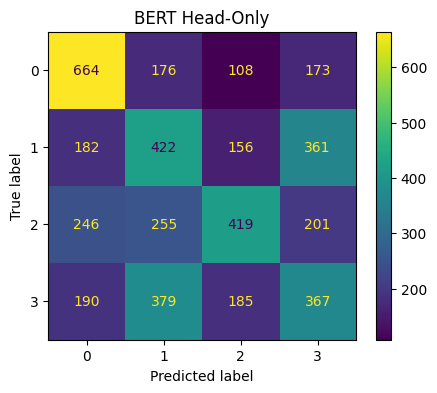

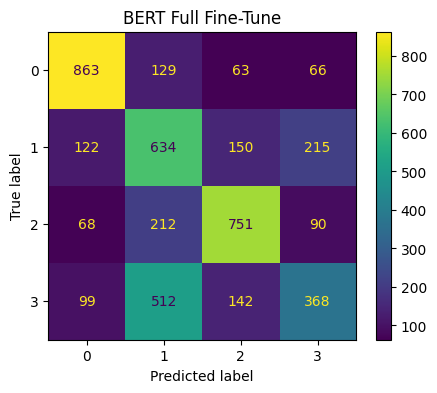

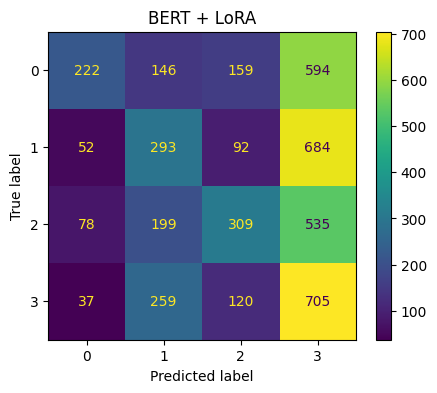

In [ ]:
import os
import logging
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    logging as hf_logging
)
from peft import PeftModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

os.environ["WANDB_DISABLED"] = "true"
hf_logging.set_verbosity_error()
logging.getLogger("peft").setLevel(logging.ERROR)

BASE = "/content/drive/MyDrive/ВКР/EmotionClassifier"

def find_ckpt(model_dir):
    for d in os.listdir(model_dir):
        p = os.path.join(model_dir, d)
        if os.path.isdir(p) and d.startswith("checkpoint"):
            return p
    raise FileNotFoundError(f"No checkpoint in {model_dir}")

head_ckpt = find_ckpt(os.path.join(BASE, "bert-head"))
full_ckpt = find_ckpt(os.path.join(BASE, "bert-full"))
lora_ckpt = find_ckpt(os.path.join(BASE, "bert-lora"))

tokenizer = AutoTokenizer.from_pretrained(head_ckpt, local_files_only=True)

model_head = AutoModelForSequenceClassification.from_pretrained(
    head_ckpt, local_files_only=True
)
model_full = AutoModelForSequenceClassification.from_pretrained(
    full_ckpt, local_files_only=True
)

# LoRA: сначала базовая модель, потом адаптер
base = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=model_full.config.num_labels,
    local_files_only=True
)
model_lora = PeftModel.from_pretrained(base, lora_ckpt, local_files_only=True)

trainer_head = Trainer(model=model_head, tokenizer=tokenizer)
trainer_full = Trainer(model=model_full, tokenizer=tokenizer)
trainer_lora = Trainer(model=model_lora, tokenizer=tokenizer)

def plot_cm(trainer, title):
    preds = trainer.predict(ds_test).predictions.argmax(-1)
    labels = ds_test["label"]
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=trainer.model.config.id2label)
    plt.figure(figsize=(5,4))
    disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
    plt.title(title)
    plt.show()

plot_cm(trainer_head, "BERT Head-Only")
plot_cm(trainer_full, "BERT Full Fine-Tune")
plot_cm(trainer_lora, "BERT + LoRA")


| Модель                          | Проблема                                                                                                                        | Решение                                                                                                    |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Full fine-tune**              | Может «забивать» редкие классы, потому что классически более частые примеры доминируют в градиентах.                            | **Class-weights** — усиливаем вклад редких примеров прямо в loss.                                          |
| **LoRA-адаптер**                | Адаптеры имеют очень мало параметров, они могут быстрее «застревать» на лёгких примерах и упускать сложные.                     | **Focal Loss** — фокусируем обучение на наиболее «трудных» (сильно дисбалансных) примерах.                 |
| **Head-only (classifier-only)** | Замороженный BERT-энкодер даёт мало изменений в представлениях, и классификатор может «переобучиться» на особенности валидации. | **Extra Dropout** — добавляем регуляризацию в голову, чтобы она не «слишком точно» повторяла шум из train. |


# Улучшаем метрики

In [ ]:
# общие импорты и константы
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import PeftModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/ВКР/EmotionClassifier"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
NUM_LABELS = ds_train.features["label"].num_classes

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }


## bert_full_weights

In [ ]:
from collections import Counter
import torch
import torch.nn as nn
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

cnt    = Counter(ds_train["label"])
counts = [cnt[i] for i in range(NUM_LABELS)]
weights = torch.tensor([1.0/c for c in counts], device=device)
weights = weights / weights.sum() * NUM_LABELS

# Определим CrossEntropyLoss с весами
loss_fn = nn.CrossEntropyLoss(weight=weights)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
).to(device)

args_full = TrainingArguments(
    output_dir="bert_full_weights",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    report_to="none",
)

trainer_full_w = WeightedTrainer(
    model=model_full,
    args=args_full,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,      
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_full_w.train()
# 15 мин 3 сек

<ipython-input-51-942955b0a536>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_full_w = WeightedTrainer(


{'loss': 1.1242, 'grad_norm': 15.31887435913086, 'learning_rate': 2.7774308652988403e-05, 'epoch': 0.22301516503122212}
{'loss': 1.0604, 'grad_norm': 7.087542533874512, 'learning_rate': 2.554415700267618e-05, 'epoch': 0.44603033006244425}
{'loss': 1.0207, 'grad_norm': 5.702059745788574, 'learning_rate': 2.3314005352363962e-05, 'epoch': 0.6690454950936664}
{'loss': 1.0014, 'grad_norm': 10.917726516723633, 'learning_rate': 2.108385370205174e-05, 'epoch': 0.8920606601248885}
{'eval_loss': 0.9874223470687866, 'eval_accuracy': 0.581530225295561, 'eval_f1_macro': 0.5772809584064351, 'eval_runtime': 4.8862, 'eval_samples_per_second': 917.474, 'eval_steps_per_second': 28.857, 'epoch': 1.0}
{'loss': 0.9267, 'grad_norm': 7.398742198944092, 'learning_rate': 1.8853702051739518e-05, 'epoch': 1.1150758251561106}
{'loss': 0.8805, 'grad_norm': 7.536899566650391, 'learning_rate': 1.6623550401427295e-05, 'epoch': 1.3380909901873328}
{'loss': 0.8721, 'grad_norm': 11.792852401733398, 'learning_rate': 1.43

TrainOutput(global_step=6726, training_loss=0.8797274773013829, metrics={'train_runtime': 900.4158, 'train_samples_per_second': 119.495, 'train_steps_per_second': 7.47, 'train_loss': 0.8797274773013829, 'epoch': 3.0})

In [ ]:
trainer_head.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert_full_weights")

Full + class-weights → Acc=0.588, F1-macro=0.588


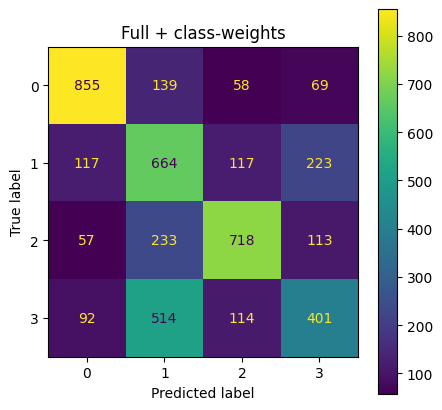

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

res = trainer_full_w.predict(ds_test)
preds = res.predictions.argmax(-1)
labels = ds_test["label"]

acc = accuracy_score(labels, preds)
f1m = f1_score(labels, preds, average="macro")
print(f"Full + class-weights → Acc={acc:.3f}, F1-macro={f1m:.3f}")

cm  = confusion_matrix(labels, preds)
disp= ConfusionMatrixDisplay(cm, display_labels=trainer_full_w.model.config.id2label)
plt.figure(figsize=(5,5))
disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
plt.title("Full + class-weights")
plt.show()

## bert_lora_focal

In [ ]:
# LoRA + Focal Loss с tqdm/ETA

import torch
import torch.nn as nn
from collections import Counter
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import PeftModel

# class‐weights для focal
cnt    = Counter(ds_train["label"])
counts = [cnt[i] for i in range(NUM_LABELS)]
weights = torch.tensor([1.0/c for c in counts], device=device)
weights = weights / weights.sum() * NUM_LABELS

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(
            logits, targets, weight=self.alpha, reduction="none"
        )
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()

focal_loss = FocalLoss(alpha=weights, gamma=2.0)

# Trainer с focal‐loss
class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        loss    = focal_loss(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

# Базовая модель + LoRA‐адаптер
base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
).to(device)

LORA_CKPT = "/content/drive/MyDrive/ВКР/EmotionClassifier/bert-lora"
model_lora = PeftModel.from_pretrained(
    base, LORA_CKPT, local_files_only=True
).to(device)

args_lora = TrainingArguments(
    output_dir="bert_lora_focal",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=1e-4,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1,
    logging_steps=50,         
    disable_tqdm=False,       
    report_to="none",        
)

trainer_lora_f = FocalTrainer(
    model=model_lora,
    args=args_lora,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_lora_f.train()


<ipython-input-60-43471a25b5f6>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer_lora_f = FocalTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.724300,0.717401,0.428285,0.408188
2,0.707600,0.709080,0.430069,0.424413
3,0.702600,0.703822,0.446353,0.446213
4,0.710700,0.701002,0.443453,0.432866
5,0.698300,0.700016,0.449922,0.440286


TrainOutput(global_step=5605, training_loss=0.7124910652796994, metrics={'train_runtime': 257.6835, 'train_samples_per_second': 695.912, 'train_steps_per_second': 21.751, 'total_flos': 1619340989963184.0, 'train_loss': 0.7124910652796994, 'epoch': 5.0})

In [ ]:
trainer_lora_f.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert_lora_focal")

Full + class-weights → Acc=0.440, F1-macro=0.440


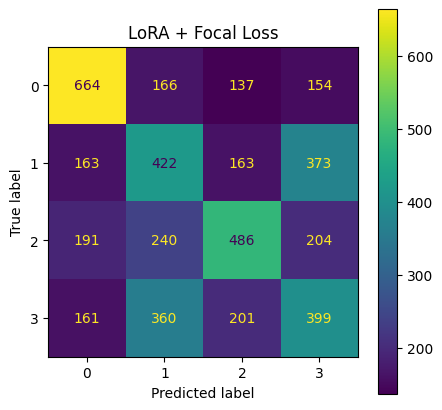

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

res = trainer_lora_f.predict(ds_test)
preds = res.predictions.argmax(-1)
labels = ds_test["labels"]

acc = accuracy_score(labels, preds)
f1m = f1_score(labels, preds, average="macro")
print(f"Full + class-weights → Acc={acc:.3f}, F1-macro={f1m:.3f}")

cm  = confusion_matrix(labels, preds)
disp= ConfusionMatrixDisplay(cm, display_labels=trainer_lora_f.model.config.id2label)
plt.figure(figsize=(5,5))
disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
plt.title("LoRA + Focal Loss")
plt.show()

## bert_head_dropout

In [ ]:
# Head-only + Extra Dropout ("vert_dropout")

import torch.nn as nn
from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from sklearn.metrics import accuracy_score, f1_score
to_keep = ["input_ids", "attention_mask", "labels"]
for ds in (ds_train, ds_val, ds_test):
    drop = [c for c in ds.column_names if c not in to_keep]
    ds = ds.remove_columns(drop)
    ds.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer)

class BertWithDropout(AutoModelForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.extra_dropout = nn.Dropout(0.3)

    def forward(self, **kwargs):
        kwargs.pop("num_items_in_batch", None)
        out = super().forward(**kwargs)
        dropped_logits = self.extra_dropout(out.logits)
        return type(out)(
            loss=out.loss,
            logits=dropped_logits,
            hidden_states=out.hidden_states,
            attentions=out.attentions,
        )

model_head = BertWithDropout.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
).to(device)
for p in model_head.base_model.parameters():
    p.requires_grad = False

def compute_metrics(p):
    preds  = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy":  accuracy_score(labels, preds),
        "f1_macro":  f1_score(labels, preds, average="macro"),
    }

args_head2 = TrainingArguments(
    output_dir="bert_head_dropout",
    eval_strategy="epoch",           
    save_strategy="epoch",         
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    num_train_epochs=5,
    save_total_limit=1,
    logging_steps=50,
    disable_tqdm=False,               
    report_to="none",
    remove_unused_columns=False,
)

trainer_head2 = Trainer(
    model=model_head,
    args=args_head2,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_head2.train()

metrics = trainer_head2.evaluate()
print(metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.374000,1.371723,0.353781,0.332846
2,1.363300,1.362451,0.344189,0.301087
3,1.355800,1.355817,0.388802,0.372574
4,1.353500,1.352325,0.375641,0.354784
5,1.347800,1.351179,0.383672,0.369601


{'eval_loss': 1.3511791229248047, 'eval_accuracy': 0.38367164844969887, 'eval_f1_macro': 0.3696005804706476, 'eval_runtime': 5.426, 'eval_samples_per_second': 826.212, 'eval_steps_per_second': 13.085, 'epoch': 5.0}


In [ ]:
trainer_head2.save_model("/content/drive/MyDrive/ВКР/EmotionClassifier/bert_head_dropout")

Full + class-weights → Acc=0.394, F1-macro=0.378


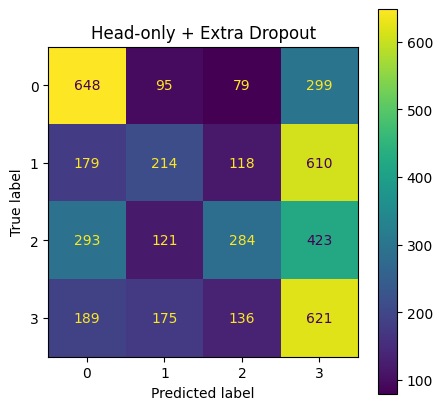

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

res = trainer_head2.predict(ds_test)
preds = res.predictions.argmax(-1)
labels = ds_test["labels"]

acc = accuracy_score(labels, preds)
f1m = f1_score(labels, preds, average="macro")
print(f"Full + class-weights → Acc={acc:.3f}, F1-macro={f1m:.3f}")

cm  = confusion_matrix(labels, preds)
disp= ConfusionMatrixDisplay(cm, display_labels=trainer_head2.model.config.id2label)
plt.figure(figsize=(5,5))
disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
plt.title("Head-only + Extra Dropout")
plt.show()

# 2.4. GPT-классификация (zero/few-shot)

In [ ]:
import time
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
gpt = OpenAI(api_key=os.getenv("sk-vc6EIwDS0CasawBWRf25q8sIs87OSuNJ"), base_url="https://api.proxyapi.ru/openai/v1")

def classify_with_gpt(text: str, examples: list[tuple[str,str]]) -> str:
    prompt = "Классифицируй по эмоции (angry, sad, neutral, positive):\n\n"
    for ex_text, ex_label in examples:
        prompt += f"Текст: «{ex_text}» → {ex_label}\n"
    prompt += f"\nТекст: «{text}» →"
    resp = gpt.chat.completions.create(model="gpt-4o-mini",
                                       messages=[{"role":"user","content":prompt}],
                                       temperature=0.0)
    return resp.choices[0].message.content.strip()

few_shot_examples = train[['speaker_text','final_emotion']].sample(4, random_state=42).values.tolist()

preds, labels = [], []
start = time.time()
for ex in ds_test:
    pred = classify_with_gpt(ex['text'], few_shot_examples)
    preds.append(pred)
    labels.append(ds_test.features['label'].int2str(ex['label']))
elapsed = time.time() - start
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
print("Accuracy:", accuracy_score(labels, preds))
print("Macro F1:", f1_score(labels, preds, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(labels, preds))
print(f"Inference time per 1000: {elapsed/len(ds_test)*1000:.2f} sec")